# 1. Tải thư viện và import nó 

In [1]:
!pip install faiss-gpu-cu12
!pip install --upgrade sentence-transformers transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 MB 38.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 8.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 84.8 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-

In [2]:
from sentence_transformers import SentenceTransformer
from transformers import pipeline
import faiss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

2025-05-21 07:02:31.864340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747810952.037190      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747810952.085813      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 2 Kiểm tra sơ bộ data 

In [4]:
df = pd.read_json("/kaggle/input/all-articles/all_articles.json")
df.head()

,url,title,content,tag
0,https://www.vinmec.com/vie/bai-viet/cang-co-du...,Căng cơ đùi: Nguyên nhân và các phương pháp đi...,Căng cơ đùi có thể coi là một trong những chấn...,Chấn thương chỉnh hình - Y khoa
1,https://www.vinmec.com/vie/bai-viet/chuot-rut-...,Chuột rút cơ lưng: Nguyên nhân và biện pháp ph...,Chuột rút cơ lưng có thể gây đau đớn và ảnh hư...,Chấn thương chỉnh hình - Y khoa
2,https://www.vinmec.com/vie/bai-viet/gay-xuong-...,Gãy xương đòn bao lâu thì tháo nẹp và những lư...,Gãy xương đòn bao lâu thì tháo nẹp là câu hỏi ...,Chấn thương chỉnh hình - Y khoa
3,https://www.vinmec.com/vie/bai-viet/cach-chua-...,Cách chữa viêm khớp cùng chậu tại nhà: Phương ...,Cách chữa viêm khớp cùng chậu tại nhà như bài ...,Chấn thương chỉnh hình - Y khoa
4,https://www.vinmec.com/vie/bai-viet/gay-xuong-...,Gãy xương cẳng tay bao lâu thì lành và những đ...,Gãy xương cẳng tay bao lâu thì lành là điều mà...,Chấn thương chỉnh hình - Y khoa


In [50]:
df.isnull().sum()

url        0
title      0
content    0
tag        0
dtype: int64

In [5]:
# Check độ dài
df['word_count'] = df['content'].apply(lambda x: len(str(x).split()))
df['char_count'] = df['content'].apply(lambda x: len(str(x)))

In [6]:
df

,url,title,content,tag,word_count,char_count
0,https://www.vinmec.com/vie/bai-viet/cang-co-du...,Căng cơ đùi: Nguyên nhân và các phương pháp đi...,Căng cơ đùi có thể coi là một trong những chấn...,Chấn thương chỉnh hình - Y khoa,1091,4977
1,https://www.vinmec.com/vie/bai-viet/chuot-rut-...,Chuột rút cơ lưng: Nguyên nhân và biện pháp ph...,Chuột rút cơ lưng có thể gây đau đớn và ảnh hư...,Chấn thương chỉnh hình - Y khoa,1367,6288
2,https://www.vinmec.com/vie/bai-viet/gay-xuong-...,Gãy xương đòn bao lâu thì tháo nẹp và những lư...,Gãy xương đòn bao lâu thì tháo nẹp là câu hỏi ...,Chấn thương chỉnh hình - Y khoa,1135,5256
3,https://www.vinmec.com/vie/bai-viet/cach-chua-...,Cách chữa viêm khớp cùng chậu tại nhà: Phương ...,Cách chữa viêm khớp cùng chậu tại nhà như bài ...,Chấn thương chỉnh hình - Y khoa,1413,6456
4,https://www.vinmec.com/vie/bai-viet/gay-xuong-...,Gãy xương cẳng tay bao lâu thì lành và những đ...,Gãy xương cẳng tay bao lâu thì lành là điều mà...,Chấn thương chỉnh hình - Y khoa,883,3994
...,...,...,...,...,...,...
38542,https://www.vinmec.com/vie/bai-viet/di-ung-pol...,"Dị ứng Polyester: Nguyên nhân, triệu chứng và ...",Dị ứng polyester là bệnh lý tương đối phổ biến...,Miễn dịch dị ứng,879,4008
38543,https://www.vinmec.com/vie/bai-viet/viem-xoang...,"Viêm xoang mũi dị ứng: Nguyên nhân, triệu chứn...",Viêm xoang mũi dị ứng là một tình trạng phổ bi...,Miễn dịch dị ứng,1486,6885
38544,https://www.vinmec.com/vie/bai-viet/roi-loan-m...,"Rối loạn miễn dịch: Các loại bệnh, nguyên nhân...",Rối loạn miễn dịch là một tình trạng bệnh mà n...,Miễn dịch dị ứng,1112,5268
38545,https://www.vinmec.com/vie/bai-viet/di-ung-nic...,Dị ứng nicotin: Các triệu chứng và cách điều trị,Dị ứng nicotin là một loại dị ứng với thành ph...,Miễn dịch dị ứng,600,2742


# 3. Tìm kiếm các bài có độ trùng lặp lớn hơn 0.9 và chỉ giữ lại 1 bài 

In [7]:
# Embed content thành vector
model = SentenceTransformer("VoVanPhuc/sup-SimCSE-VietNamese-phobert-base")
embeddings = model.encode(df['content'].tolist(), show_progress_bar=True)
# Normalize
faiss.normalize_L2(embeddings)

# Tạo FAISS index CPU
index_cpu = faiss.IndexFlatIP(embeddings.shape[1])

# Cấu hình để dùng 1 GPU (GPU 0)
gpu_id = 0  # Sử dụng GPU 0
res = faiss.StandardGpuResources()  # Tạo một resource cho GPU

# Chuyển index từ CPU sang GPU
index_gpu = faiss.index_cpu_to_gpu(res, gpu_id, index_cpu)

# Thêm embeddings vào index
index_gpu.add(embeddings)

# Tìm top k
k = 5
D, I = index_gpu.search(embeddings, k)

# Lọc cặp giống nhau
threshold = 0.95
similar_pairs = set()
results = []
for i in range(len(I)):
    for j, sim in zip(I[i], D[i]):
        if i != j and sim > threshold:
            pair = tuple(sorted((i, j)))
            if pair not in similar_pairs:
                similar_pairs.add(pair)
                results.append((i, j, sim))

# In kết quả
print(f"Tổng số cặp có similarity > {threshold}: {len(results)}\n")
print("5 cặp đầu tiên:")
for i, j, sim in results[:5]:
    print(f"Pair ({i}, {j}) - Similarity: {sim:.2f}")

config.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Batches:   0%|          | 0/1205 [00:00<?, ?it/s]

Tổng số cặp có similarity > 0.95: 3922

5 cặp đầu tiên:
Pair (0, 8) - Similarity: 1.00
Pair (1, 9) - Similarity: 1.00
Pair (2, 10) - Similarity: 1.00
Pair (3, 11) - Similarity: 1.00
Pair (4, 12) - Similarity: 1.00


In [8]:
# Tìm các bài viết cần loại bỏ (chỉ giữ lại bài có index i trong mỗi cặp)
to_remove = set()
for i, j, _ in results:
    # Thêm j vào danh sách bài cần loại bỏ
    to_remove.add(j)

# Tính số lượng bài viết ban đầu
total_articles = len(df)

# Loại bỏ trực tiếp các bài trùng lặp khỏi DataFrame
df_filtered = df.drop(index=list(to_remove))

# In thông tin về quá trình lọc
print(f"\nSố lượng bài viết ban đầu: {total_articles}")
print(f"Số lượng bài viết trùng lặp đã loại bỏ: {len(to_remove)}")
print(f"Số lượng bài viết còn lại sau khi lọc: {len(df_filtered)}")


Số lượng bài viết ban đầu: 38547
Số lượng bài viết trùng lặp đã loại bỏ: 3007
Số lượng bài viết còn lại sau khi lọc: 35540


In [9]:
df_filtered

,url,title,content,tag,word_count,char_count
0,https://www.vinmec.com/vie/bai-viet/cang-co-du...,Căng cơ đùi: Nguyên nhân và các phương pháp đi...,Căng cơ đùi có thể coi là một trong những chấn...,Chấn thương chỉnh hình - Y khoa,1091,4977
1,https://www.vinmec.com/vie/bai-viet/chuot-rut-...,Chuột rút cơ lưng: Nguyên nhân và biện pháp ph...,Chuột rút cơ lưng có thể gây đau đớn và ảnh hư...,Chấn thương chỉnh hình - Y khoa,1367,6288
2,https://www.vinmec.com/vie/bai-viet/gay-xuong-...,Gãy xương đòn bao lâu thì tháo nẹp và những lư...,Gãy xương đòn bao lâu thì tháo nẹp là câu hỏi ...,Chấn thương chỉnh hình - Y khoa,1135,5256
3,https://www.vinmec.com/vie/bai-viet/cach-chua-...,Cách chữa viêm khớp cùng chậu tại nhà: Phương ...,Cách chữa viêm khớp cùng chậu tại nhà như bài ...,Chấn thương chỉnh hình - Y khoa,1413,6456
4,https://www.vinmec.com/vie/bai-viet/gay-xuong-...,Gãy xương cẳng tay bao lâu thì lành và những đ...,Gãy xương cẳng tay bao lâu thì lành là điều mà...,Chấn thương chỉnh hình - Y khoa,883,3994
...,...,...,...,...,...,...
38542,https://www.vinmec.com/vie/bai-viet/di-ung-pol...,"Dị ứng Polyester: Nguyên nhân, triệu chứng và ...",Dị ứng polyester là bệnh lý tương đối phổ biến...,Miễn dịch dị ứng,879,4008
38543,https://www.vinmec.com/vie/bai-viet/viem-xoang...,"Viêm xoang mũi dị ứng: Nguyên nhân, triệu chứn...",Viêm xoang mũi dị ứng là một tình trạng phổ bi...,Miễn dịch dị ứng,1486,6885
38544,https://www.vinmec.com/vie/bai-viet/roi-loan-m...,"Rối loạn miễn dịch: Các loại bệnh, nguyên nhân...",Rối loạn miễn dịch là một tình trạng bệnh mà n...,Miễn dịch dị ứng,1112,5268
38545,https://www.vinmec.com/vie/bai-viet/di-ung-nic...,Dị ứng nicotin: Các triệu chứng và cách điều trị,Dị ứng nicotin là một loại dị ứng với thành ph...,Miễn dịch dị ứng,600,2742


# 4. Vẽ biểu đồ 

In [20]:
df_filtered.drop(['word_count', 'char_count'], axis=1, inplace=True)

KeyError: "['word_count', 'char_count'] not found in axis"

In [11]:
df = df_filtered.copy()

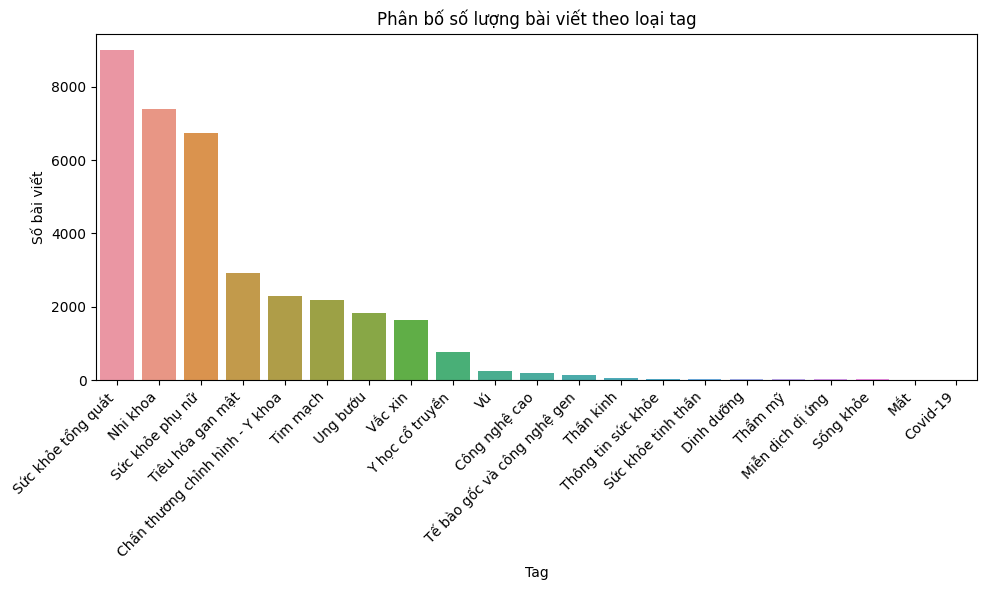

In [12]:
# Đếm số bài viết theo tag
tag_counts = df['tag'].value_counts()

# --- Biểu đồ cột ---
plt.figure(figsize=(10,6))
sns.barplot(x=tag_counts.index, y=tag_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title('Phân bố số lượng bài viết theo loại tag')
plt.ylabel('Số bài viết')
plt.xlabel('Tag')
plt.tight_layout()
plt.show()

In [13]:
# Tách các bài viết là dạng Question and Answer 
df_qa = df[df['content'].str.startswith("Hỏi\nChào bác sĩ", na=False)].copy()
# Tách các bài viết còn lại là dạng article 
df_article = df[~df['content'].str.startswith("Hỏi\nChào bác sĩ", na=False)].copy()

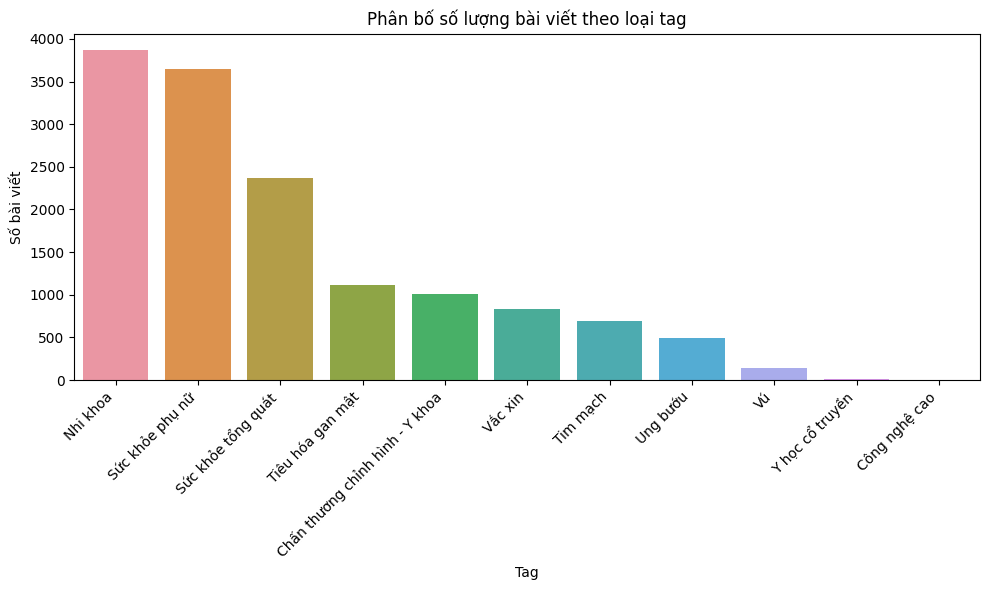

In [14]:
# Đếm số bài viết theo tag
tag_counts = df_qa['tag'].value_counts()

# --- Biểu đồ cột ---
plt.figure(figsize=(10,6))
sns.barplot(x=tag_counts.index, y=tag_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title('Phân bố số lượng bài viết theo loại tag')
plt.ylabel('Số bài viết')
plt.xlabel('Tag')
plt.tight_layout()
plt.show()

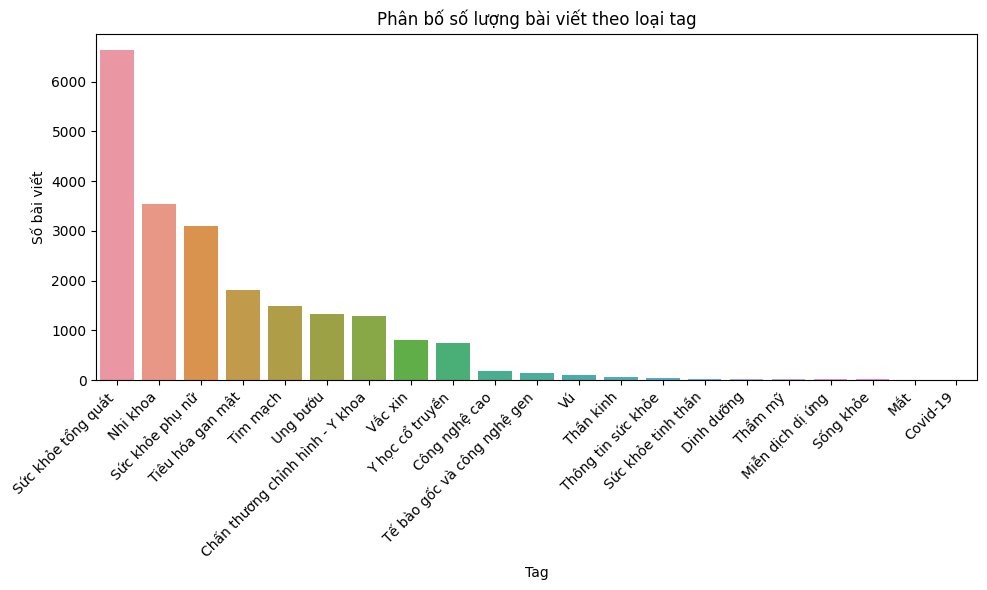

In [15]:
# Đếm số bài viết theo tag
tag_counts = df_article['tag'].value_counts()

# --- Biểu đồ cột ---
plt.figure(figsize=(10,6))
sns.barplot(x=tag_counts.index, y=tag_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title('Phân bố số lượng bài viết theo loại tag')
plt.ylabel('Số bài viết')
plt.xlabel('Tag')
plt.tight_layout()
plt.show()

# 5. Xử lý từng df và thêm meta data

1. Xóa bỏ dấu "\n"
2. Tiến hành reformat lại các dictionary về thành format chuẩn 


## 1. Xử lý df_qa 

In [16]:
# Thay thế \n trong cột content bằng dấu cách
df_qa.loc[:, 'content'] = df_qa['content'].str.replace('\n', ' ', regex=False)

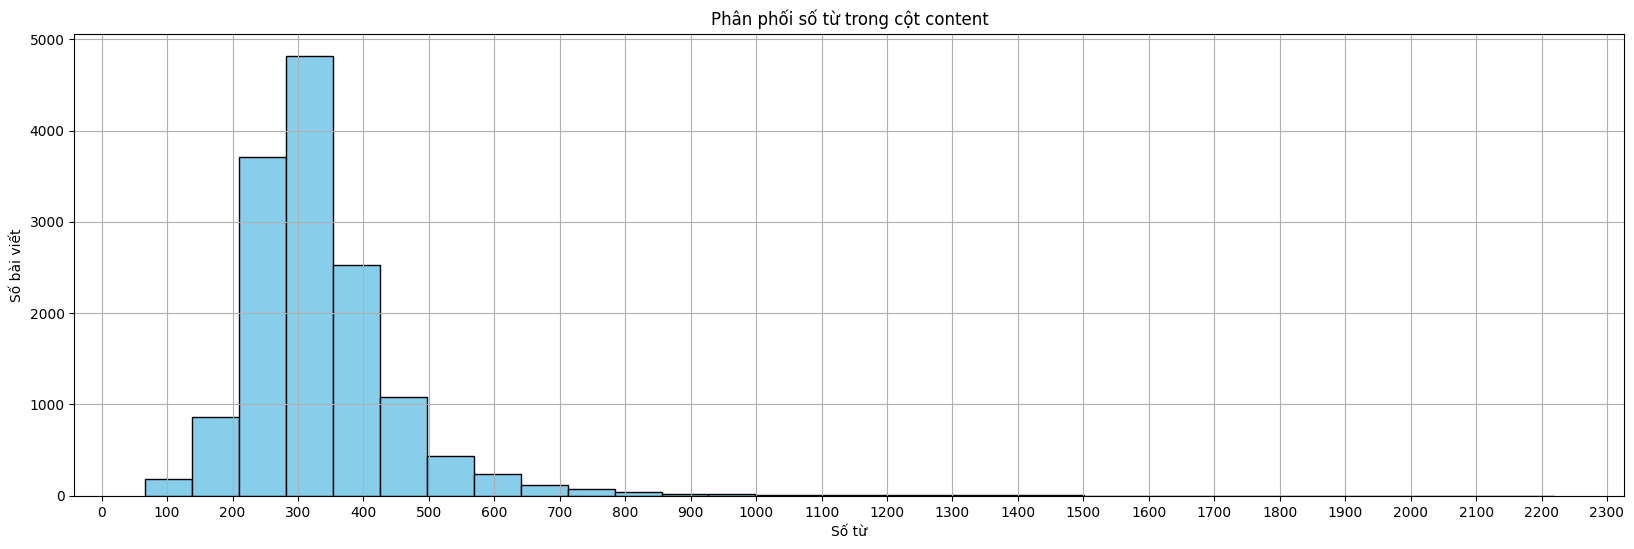

In [23]:
# Đếm số từ cho từng dòng trong cột 'content'
word_counts = df_qa['content'].str.split().str.len()

# Vẽ biểu đồ histogram
plt.figure(figsize=(20, 6))
plt.hist(word_counts, bins=30, color='skyblue', edgecolor='black')
plt.title('Phân phối số từ trong cột content')
plt.xlabel('Số từ')
plt.ylabel('Số bài viết')
plt.xticks(np.arange(0, max(word_counts) + 100, 100))
plt.grid(True)
plt.show()

In [24]:
df_qa['content']

300      Em là nam, sinh năm 2005. Hồi đầu tháng 6, em ...
301      Cháu thường xuyên bị đau gót chân và bàn chân....
302      Em mới mổ xương đòn được 1 năm 4 tháng, em đan...
303      Em bị đứt dây thần kinh trụ cổ tay phải từ giữ...
304      Cháu bị gãy đầu dưới xương quay nay đã được 4 ...
                               ...                        
38296    tôi đang có ý định sử dụng thuốc Đông y để điề...
38297    tôi đang sử dụng thuốc Đông Y để điều trị mất ...
38331    Tôi bị đau dạ dày mãn tính, hiện đã bắt đầu sử...
38332    Tôi đã sử dụng thuốc Đông y được một thời gian...
38333    tôi bị bệnh khớp lâu năm và hiện đang điều trị...
Name: content, Length: 14181, dtype: object

In [25]:
df_qa['content'] = df_qa['content'].str.replace(r'^Hỏi\s*Chào bác sĩ,?\s*', '', regex=True)

In [26]:
for text in df_qa['content'].head(5):
    print(text)
    print('-' * 80)

Em là nam, sinh năm 2005. Hồi đầu tháng 6, em có bị “bong điểm bám dây chằng chéo trước”, bác sĩ chỉ định mổ đóng đinh và đến nay cũng được 4 tháng rưỡi, em muốn tập thể dục để nâng cao sức khoẻ. Bác sĩ cho em hỏisau mổ bong điểm bám dây chằng chéo trước bao lâu có thể tập thể dục?Bao lâu em có thể chạy bộ và hoạt động chạy nhảy bình thường được? Em có cần bỏ đinh ra mới hoạt động bình thường được không? Em cảm ơn. Khách hàng ẩn danh Trả lời Được giải đáp bởiThạc sĩ, Bác sĩ Hoàng Xuân Hùng- Khoa Ngoại tổng hợp, Bệnh viện Đa khoa Quốc tế Vinmec Nha Trang. Chào bạn, Với câu hỏi “Sau mổ bong điểm bám dây chằng chéo trước bao lâu có thể tập thể dục?”, bác sĩ xin giải đáp như sau: Về tình trạng của bạn nếu ca phẫu thuật thuận lợi và đúng phương pháp thì bạn có thể tập vận động từ 4 - 6 tuần sau mổ, bắt đầu đặt chân chịu lực từ tuần thứ 6 và sau 8 tuần cần được mở hết tầm vận động. Bạn đã phẫu thuật 4 tháng hơn nên đi khám lại để bác sĩ phẫu thuật có lời khuyên cụ thể hơn. Nếu bạn còn thắc m

In [34]:
pattern = r"Nếu bạn còn thắc mắc về.*?mọi lúc mọi nơi ngay trên ứng dụng\."
df_qa['content'] = df_qa['content'].str.replace(pattern, '', regex=True)

In [28]:
df_qa.loc[:, 'content'] = df_qa['content'].str.replace(r'Khách hàng ẩn danh.*?\.', '', regex=True)

In [29]:
df_qa.loc[:, 'content'] = df_qa['content'].str.replace(r' Chào bạn,.*?(?=bác sĩ xin giải đáp như sau)', '', regex=True)

In [35]:
for text in df_qa['content'].head(5):
    print(text)
    print('-' * 80)

Em là nam, sinh năm 2005. Hồi đầu tháng 6, em có bị “bong điểm bám dây chằng chéo trước”, bác sĩ chỉ định mổ đóng đinh và đến nay cũng được 4 tháng rưỡi, em muốn tập thể dục để nâng cao sức khoẻ. Bác sĩ cho em hỏisau mổ bong điểm bám dây chằng chéo trước bao lâu có thể tập thể dục?Bao lâu em có thể chạy bộ và hoạt động chạy nhảy bình thường được? Em có cần bỏ đinh ra mới hoạt động bình thường được không? Em cảm ơn. bác sĩ xin giải đáp như sau: Về tình trạng của bạn nếu ca phẫu thuật thuận lợi và đúng phương pháp thì bạn có thể tập vận động từ 4 - 6 tuần sau mổ, bắt đầu đặt chân chịu lực từ tuần thứ 6 và sau 8 tuần cần được mở hết tầm vận động. Bạn đã phẫu thuật 4 tháng hơn nên đi khám lại để bác sĩ phẫu thuật có lời khuyên cụ thể hơn. 
--------------------------------------------------------------------------------
Cháu thường xuyên bị đau gót chân và bàn chân. Nếu đi lại nhiều thì gót chân đau hơn rất nhiều và hay bị nóng ở bàn chân. Vậy bác sĩ cho cháu hỏiđau gót chân và bàn chân là 

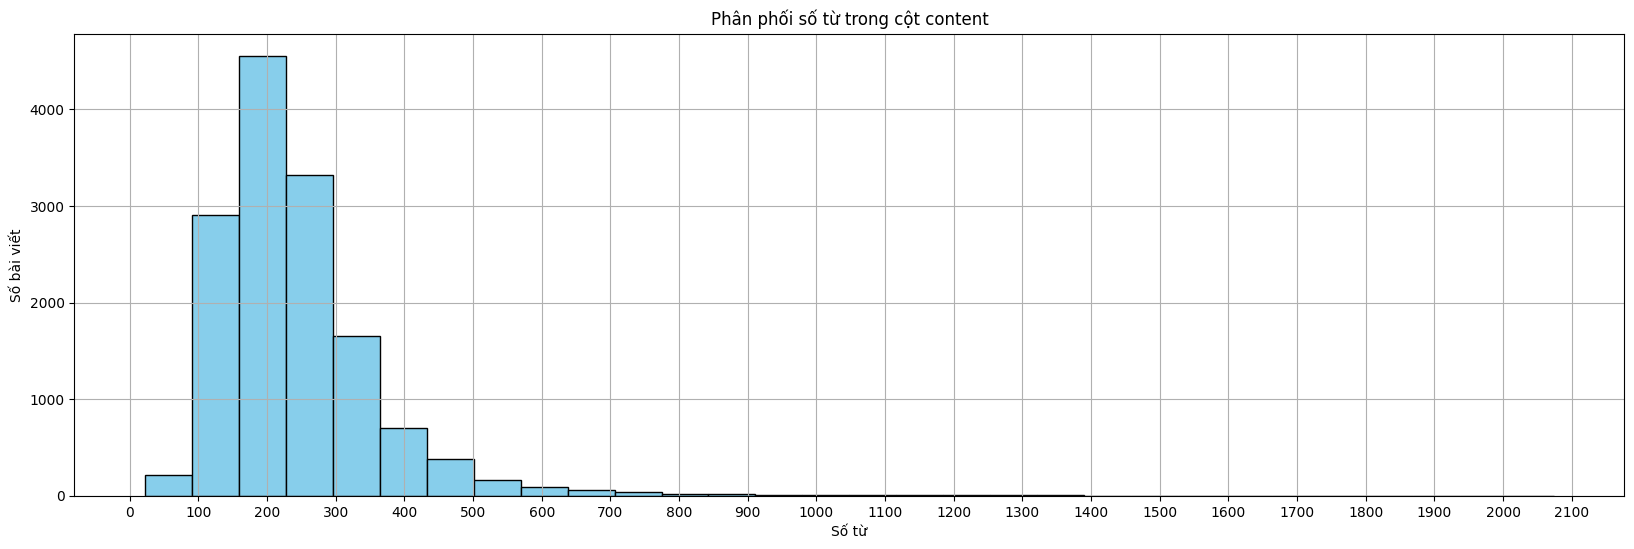

In [36]:
# Đếm số từ cho từng dòng trong cột 'content'
word_counts = df_qa['content'].str.split().str.len()

# Vẽ biểu đồ histogram
plt.figure(figsize=(20, 6))
plt.hist(word_counts, bins=30, color='skyblue', edgecolor='black')
plt.title('Phân phối số từ trong cột content')
plt.xlabel('Số từ')
plt.ylabel('Số bài viết')
plt.xticks(np.arange(0, max(word_counts) + 100, 100))
plt.grid(True)
plt.show()

In [37]:
# Thêm cột này ở cuối để khi merge lại với cái df_article thì sẽ phân biệt dễ hơn 
df_qa['type'] = 'qa'

In [39]:
df_qa.head()

,url,title,content,tag,type
300,https://www.vinmec.com/vie/bai-viet/sau-mo-bon...,Sau mổ bong điểm bám dây chằng chéo trước bao ...,"Em là nam, sinh năm 2005. Hồi đầu tháng 6, em ...",Chấn thương chỉnh hình - Y khoa,qa
301,https://www.vinmec.com/vie/bai-viet/dau-got-ch...,Đau gót chân và bàn chân là bệnh gì?,Cháu thường xuyên bị đau gót chân và bàn chân....,Chấn thương chỉnh hình - Y khoa,qa
302,https://www.vinmec.com/vie/bai-viet/co-mo-rut-...,Có thể mổ rút nẹp xương đòn sau 2 năm được không?,"Em mới mổ xương đòn được 1 năm 4 tháng, em đan...",Chấn thương chỉnh hình - Y khoa,qa
303,https://www.vinmec.com/vie/bai-viet/dut-day-ki...,Đứt dây thần kinh trụ cổ tay nên tập luyện hồi...,Em bị đứt dây thần kinh trụ cổ tay phải từ giữ...,Chấn thương chỉnh hình - Y khoa,qa
304,https://www.vinmec.com/vie/bai-viet/gay-dau-du...,Gãy đầu dưới xương quay có sao không?,Cháu bị gãy đầu dưới xương quay nay đã được 4 ...,Chấn thương chỉnh hình - Y khoa,qa


## 2. Xử lý df_article 

In [40]:
df_article

,url,title,content,tag
0,https://www.vinmec.com/vie/bai-viet/cang-co-du...,Căng cơ đùi: Nguyên nhân và các phương pháp đi...,Căng cơ đùi có thể coi là một trong những chấn...,Chấn thương chỉnh hình - Y khoa
1,https://www.vinmec.com/vie/bai-viet/chuot-rut-...,Chuột rút cơ lưng: Nguyên nhân và biện pháp ph...,Chuột rút cơ lưng có thể gây đau đớn và ảnh hư...,Chấn thương chỉnh hình - Y khoa
2,https://www.vinmec.com/vie/bai-viet/gay-xuong-...,Gãy xương đòn bao lâu thì tháo nẹp và những lư...,Gãy xương đòn bao lâu thì tháo nẹp là câu hỏi ...,Chấn thương chỉnh hình - Y khoa
3,https://www.vinmec.com/vie/bai-viet/cach-chua-...,Cách chữa viêm khớp cùng chậu tại nhà: Phương ...,Cách chữa viêm khớp cùng chậu tại nhà như bài ...,Chấn thương chỉnh hình - Y khoa
4,https://www.vinmec.com/vie/bai-viet/gay-xuong-...,Gãy xương cẳng tay bao lâu thì lành và những đ...,Gãy xương cẳng tay bao lâu thì lành là điều mà...,Chấn thương chỉnh hình - Y khoa
...,...,...,...,...
38542,https://www.vinmec.com/vie/bai-viet/di-ung-pol...,"Dị ứng Polyester: Nguyên nhân, triệu chứng và ...",Dị ứng polyester là bệnh lý tương đối phổ biến...,Miễn dịch dị ứng
38543,https://www.vinmec.com/vie/bai-viet/viem-xoang...,"Viêm xoang mũi dị ứng: Nguyên nhân, triệu chứn...",Viêm xoang mũi dị ứng là một tình trạng phổ bi...,Miễn dịch dị ứng
38544,https://www.vinmec.com/vie/bai-viet/roi-loan-m...,"Rối loạn miễn dịch: Các loại bệnh, nguyên nhân...",Rối loạn miễn dịch là một tình trạng bệnh mà n...,Miễn dịch dị ứng
38545,https://www.vinmec.com/vie/bai-viet/di-ung-nic...,Dị ứng nicotin: Các triệu chứng và cách điều trị,Dị ứng nicotin là một loại dị ứng với thành ph...,Miễn dịch dị ứng


In [43]:
# Thêm cột này ở cuối để khi merge lại với cái df_qa thì sẽ phân biệt dễ hơn 
df_article['type'] = 'article'

In [44]:
df_article.head()

,url,title,content,tag,type
0,https://www.vinmec.com/vie/bai-viet/cang-co-du...,Căng cơ đùi: Nguyên nhân và các phương pháp đi...,Căng cơ đùi có thể coi là một trong những chấn...,Chấn thương chỉnh hình - Y khoa,article
1,https://www.vinmec.com/vie/bai-viet/chuot-rut-...,Chuột rút cơ lưng: Nguyên nhân và biện pháp ph...,Chuột rút cơ lưng có thể gây đau đớn và ảnh hư...,Chấn thương chỉnh hình - Y khoa,article
2,https://www.vinmec.com/vie/bai-viet/gay-xuong-...,Gãy xương đòn bao lâu thì tháo nẹp và những lư...,Gãy xương đòn bao lâu thì tháo nẹp là câu hỏi ...,Chấn thương chỉnh hình - Y khoa,article
3,https://www.vinmec.com/vie/bai-viet/cach-chua-...,Cách chữa viêm khớp cùng chậu tại nhà: Phương ...,Cách chữa viêm khớp cùng chậu tại nhà như bài ...,Chấn thương chỉnh hình - Y khoa,article
4,https://www.vinmec.com/vie/bai-viet/gay-xuong-...,Gãy xương cẳng tay bao lâu thì lành và những đ...,Gãy xương cẳng tay bao lâu thì lành là điều mà...,Chấn thương chỉnh hình - Y khoa,article


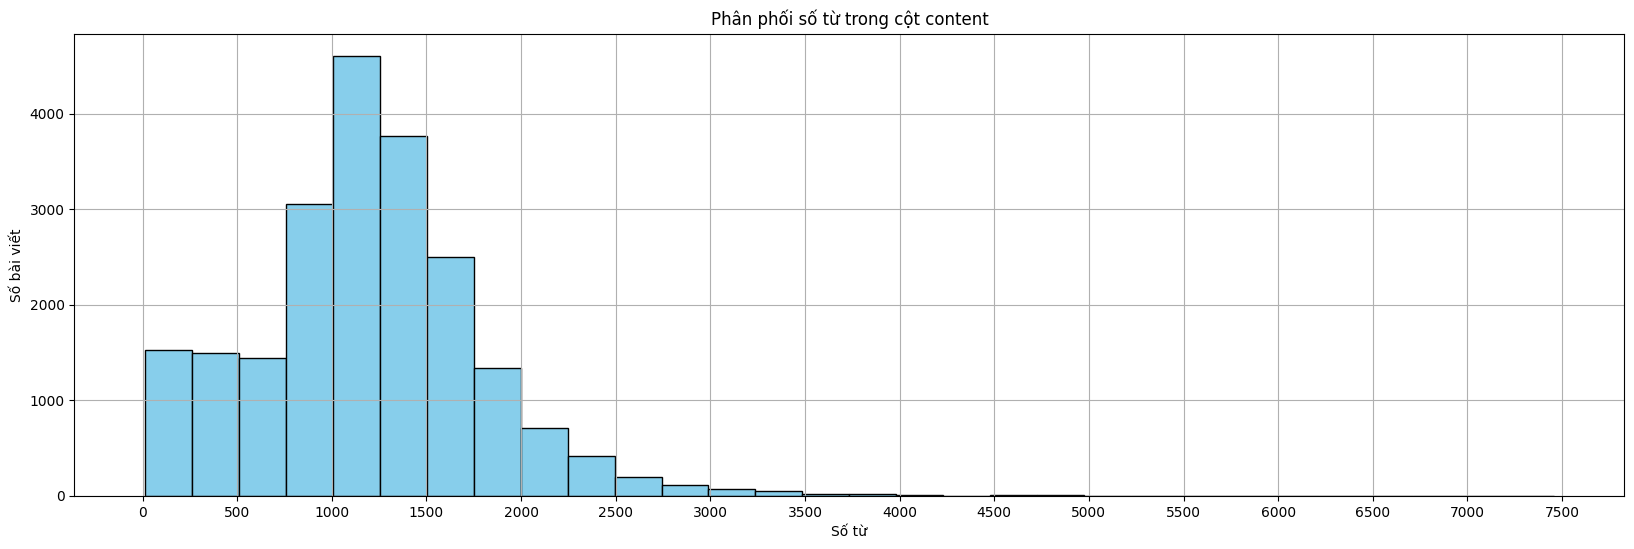

In [47]:
# Đếm số từ cho từng dòng trong cột 'content'
word_counts = df_article['content'].str.split().str.len()

# Vẽ biểu đồ histogram
plt.figure(figsize=(20, 6))
plt.hist(word_counts, bins=30, color='skyblue', edgecolor='black')
plt.title('Phân phối số từ trong cột content')
plt.xlabel('Số từ')
plt.ylabel('Số bài viết')
plt.xticks(np.arange(0, max(word_counts) + 500, 500))
plt.grid(True)
plt.show()

In [55]:
import json

# Lưu df_qa
with open('df_qa.json', 'w', encoding='utf-8') as f:
    json.dump(df_qa.to_dict(orient='records'), f, ensure_ascii=False, indent=2)

# Lưu df_article
with open('df_article.json', 'w', encoding='utf-8') as f:
    json.dump(df_article.to_dict(orient='records'), f, ensure_ascii=False, indent=2)